In [14]:
import sys
import os

# Add the parent directory 'experiments' to sys.path
sys.path.append(os.path.abspath('..'))

from models.PhysicsModel import OmniRobotDynamic

In [15]:
import pandas as pd

df = pd.read_csv("../dataset/processed_data/data0.csv")
df.head()

,vx,vy,omega,vx_cmd,vy_cmd,omega_cmd,filtered_x,filtered_y,x,y,filtered_theta
0,0.000000,0.000000,0.000000,0.0,0.0,-3.41724,-0.141153,-0.082645,-0.141153,-0.082645,1.381510
1,-0.047538,0.278635,-0.137952,0.0,0.0,-3.65059,-0.142632,-0.073978,-0.142975,-0.071965,1.376339
2,-0.068834,0.396873,-0.308679,0.0,0.0,-3.86224,-0.144346,-0.064222,-0.144808,-0.061659,1.365359
3,-0.081398,0.465380,-0.466342,0.0,0.0,-4.06502,-0.146147,-0.054059,-0.146638,-0.051382,1.350402
4,-0.090642,0.508263,-0.648098,0.0,0.0,-4.23785,-0.148028,-0.043929,-0.148531,-0.041596,1.329527


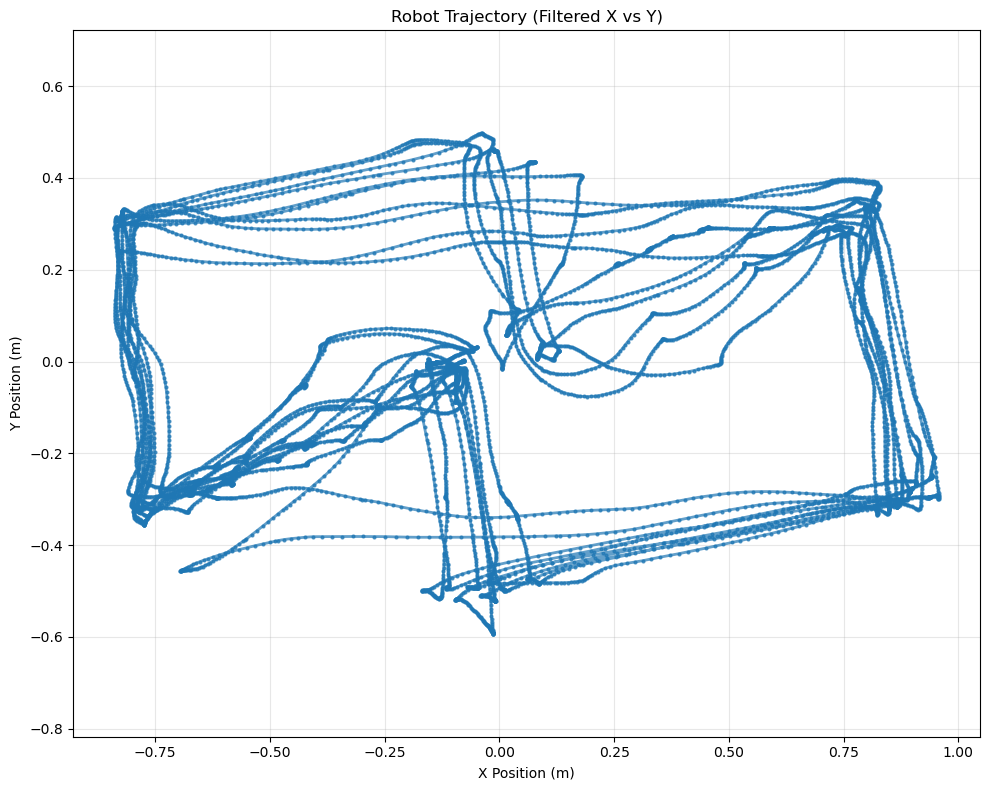

In [16]:
import matplotlib.pyplot as plt
# Create the plot
plt.figure(figsize=(10, 8))
plt.plot(df['filtered_x'], df['filtered_y'], linewidth=2, marker='o', markersize=2, alpha=0.7)
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Robot Trajectory (Filtered X vs Y)')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

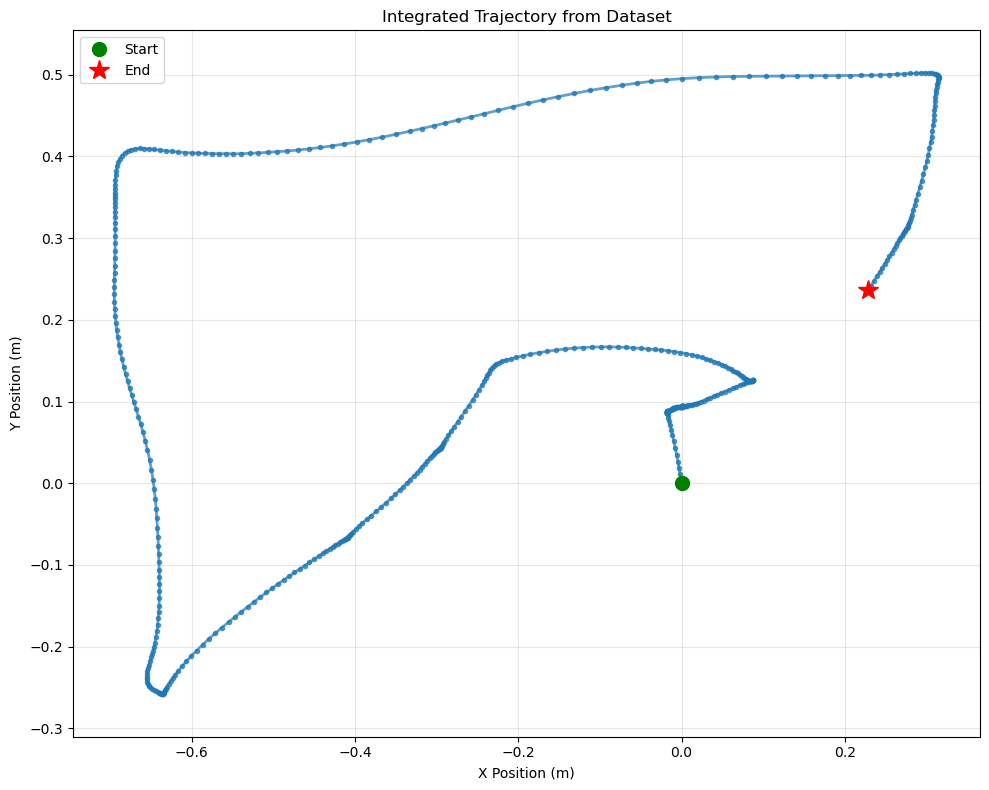

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_trajectory_from_velocities(velocities, dt=0.016, title="Robot Trajectory"):
    """
    Plots the trajectory of a robot by integrating velocities using Euler method.
    
    Args:
        velocities: List of tuples (vx, vy, omega) representing velocities at each time step
        dt: Time step for integration (seconds), default 0.01
        title: Title for the plot
    """
    # Initialize position and heading
    x, y, theta = 0.0, 0.0, 0.0
    positions_x = [x]
    positions_y = [y]
    
    # Integrate velocities to get positions
    for vx, vy, omega in velocities:
        # Update heading
        theta += omega * dt
        
        # Update position in global frame
        x += vx * dt
        y += vy * dt
        
        positions_x.append(x)
        positions_y.append(y)
    
    # Plot the trajectory
    plt.figure(figsize=(10, 8))
    plt.plot(positions_x, positions_y, linewidth=2, marker='o', markersize=3, alpha=0.7)
    plt.plot(positions_x[0], positions_y[0], 'go', markersize=10, label='Start')
    plt.plot(positions_x[-1], positions_y[-1], 'r*', markersize=15, label='End')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Example usage with your dataframe
velocities = list(zip(df['vx'], df['vy'], df['omega']))
velocities = velocities[:500]
plot_trajectory_from_velocities(velocities, title="Integrated Trajectory from Dataset")

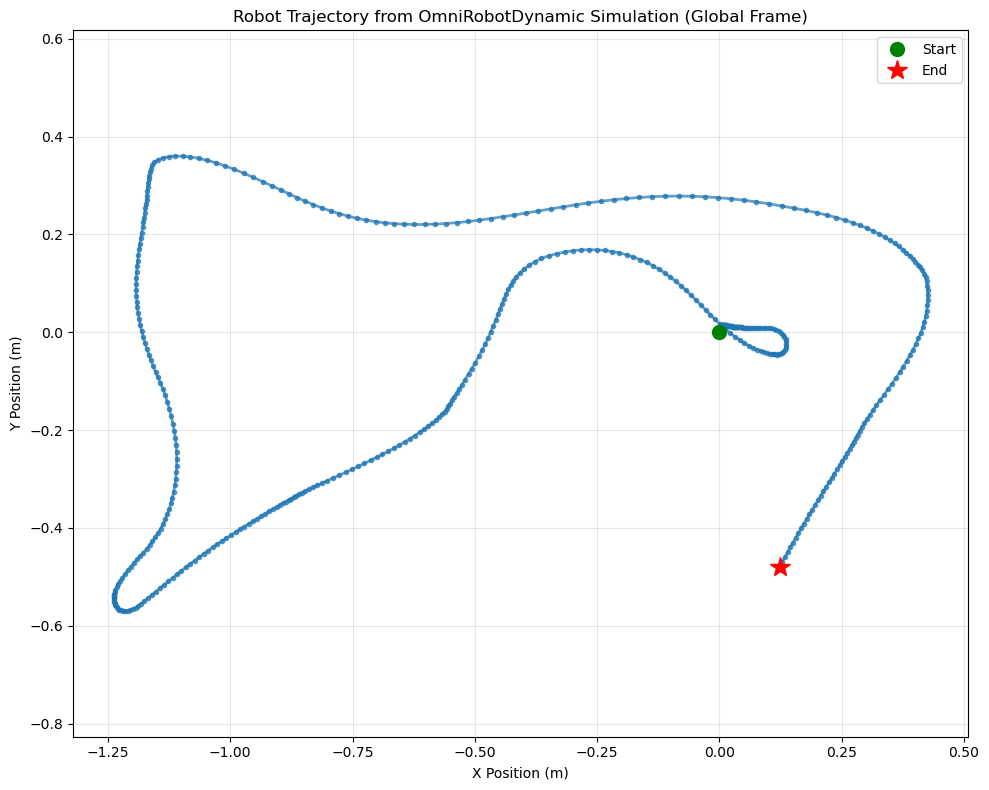

In [18]:
import torch

# Extract command velocities from dataframe
commands_list = list(zip(df['vx_cmd'], df['vy_cmd'], df['omega_cmd']))
commands_list = commands_list[:500]

# Initialize robot
robot = OmniRobotDynamic(dt=0.016)
robot.eval()  # Set to evaluation mode

# Initial state [vx, vy, omega, theta]
state = torch.zeros((1, 4)) 
simulated_velocities = []

with torch.no_grad():  # No gradient computation during inference
    for cmd in commands_list:
        # Convert command to tensor
        cmd_tensor = torch.tensor([[cmd[0], cmd[1], cmd[2]]], dtype=torch.float32)
        
        # Forward pass
        state = robot(state, cmd_tensor)
        
        # Convert to numpy and append
        vx, vy, omega = state[0, 0].item(), state[0, 1].item(), state[0, 2].item()
        theta_val = state[0, 3].item()
        
        # Convert robot body velocities (local) to world frame (global) for plotting
        # Note: The PhysicsModel operates in local frame for dynamics, so vx/vy are local.
        # We transform them to global frame using the current heading.
        cos_t = np.cos(theta_val)
        sin_t = np.sin(theta_val)
        
        vx_global = cos_t * vx - sin_t * vy
        vy_global = sin_t * vx + cos_t * vy
        
        simulated_velocities.append((vx_global, vy_global, omega))

# Plot the trajectory from simulated velocities in global frame
plot_trajectory_from_velocities(simulated_velocities, dt=0.016, 
                                 title="Robot Trajectory from OmniRobotDynamic Simulation (Global Frame)")

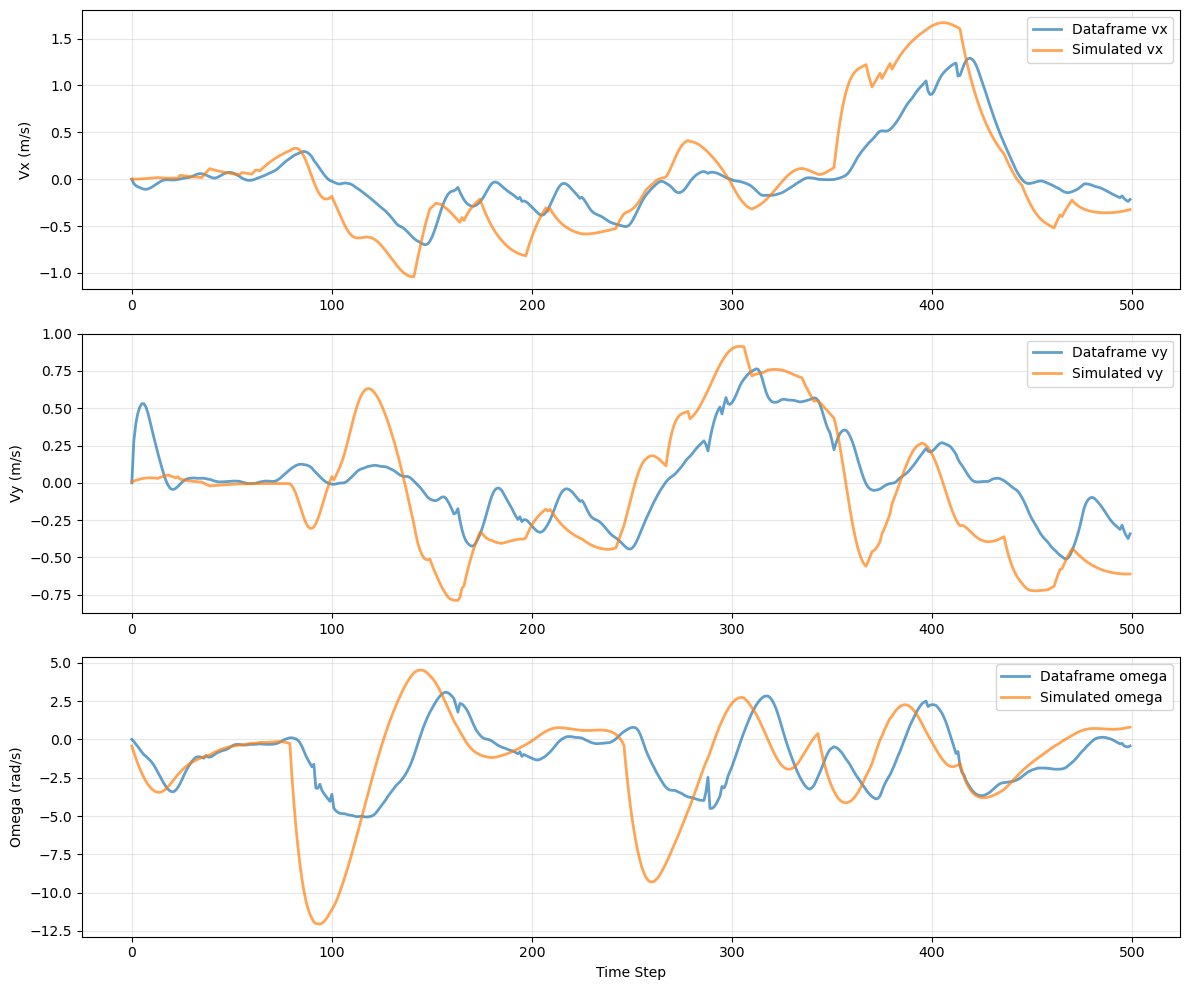

Velocity Frame Consistency Check:
Vx Mean Error: 0.260505 m/s
Vy Mean Error: 0.238703 m/s
Omega Mean Error: 2.037063 rad/s
Vx Match: 15.00%
Vy Match: 20.20%
Omega Match: 3.40%


In [20]:
def check_velocity_frame_consistency(df, simulated_velocities, dt=0.016, tolerance=0.05):
    """
    Compares simulated velocities from OmniRobotDynamic with dataframe velocities
    to check if they are in the same frame.
    
    Args:
        df: Pandas dataframe with 'vx', 'vy', 'omega' columns (actual velocities)
        simulated_velocities: List of tuples (vx, vy, omega) from robot simulation
        dt: Time step for integration
        tolerance: Acceptable error threshold for matching
    
    Returns:
        dict: Statistics and comparison results
    """
    # Extract actual velocities from dataframe
    actual_vx = df['vx'].values[:len(simulated_velocities)]
    actual_vy = df['vy'].values[:len(simulated_velocities)]
    actual_omega = df['omega'].values[:len(simulated_velocities)]
    
    # Extract simulated velocities
    sim_vx = np.array([v[0] for v in simulated_velocities])
    sim_vy = np.array([v[1] for v in simulated_velocities])
    sim_omega = np.array([v[2] for v in simulated_velocities])
    
    # Calculate errors
    error_vx = np.abs(actual_vx - sim_vx)
    error_vy = np.abs(actual_vy - sim_vy)
    error_omega = np.abs(actual_omega - sim_omega)
    
    # Statistics
    results = {
        'vx_mean_error': np.mean(error_vx),
        'vy_mean_error': np.mean(error_vy),
        'omega_mean_error': np.mean(error_omega),
        'vx_max_error': np.max(error_vx),
        'vy_max_error': np.max(error_vy),
        'omega_max_error': np.max(error_omega),
        'vx_match_percentage': np.sum(error_vx < tolerance) / len(error_vx) * 100,
        'vy_match_percentage': np.sum(error_vy < tolerance) / len(error_vy) * 100,
        'omega_match_percentage': np.sum(error_omega < tolerance) / len(error_omega) * 100,
    }
    
    # Plot comparison
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    
    axes[0].plot(actual_vx, label='Dataframe vx', linewidth=2, alpha=0.7)
    axes[0].plot(sim_vx, label='Simulated vx', linewidth=2, alpha=0.7)
    axes[0].set_ylabel('Vx (m/s)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(actual_vy, label='Dataframe vy', linewidth=2, alpha=0.7)
    axes[1].plot(sim_vy, label='Simulated vy', linewidth=2, alpha=0.7)
    axes[1].set_ylabel('Vy (m/s)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(actual_omega, label='Dataframe omega', linewidth=2, alpha=0.7)
    axes[2].plot(sim_omega, label='Simulated omega', linewidth=2, alpha=0.7)
    axes[2].set_xlabel('Time Step')
    axes[2].set_ylabel('Omega (rad/s)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Usage
results = check_velocity_frame_consistency(df, simulated_velocities, dt=0.016, tolerance=0.05)
print("Velocity Frame Consistency Check:")
print(f"Vx Mean Error: {results['vx_mean_error']:.6f} m/s")
print(f"Vy Mean Error: {results['vy_mean_error']:.6f} m/s")
print(f"Omega Mean Error: {results['omega_mean_error']:.6f} rad/s")
print(f"Vx Match: {results['vx_match_percentage']:.2f}%")
print(f"Vy Match: {results['vy_match_percentage']:.2f}%")
print(f"Omega Match: {results['omega_match_percentage']:.2f}%")

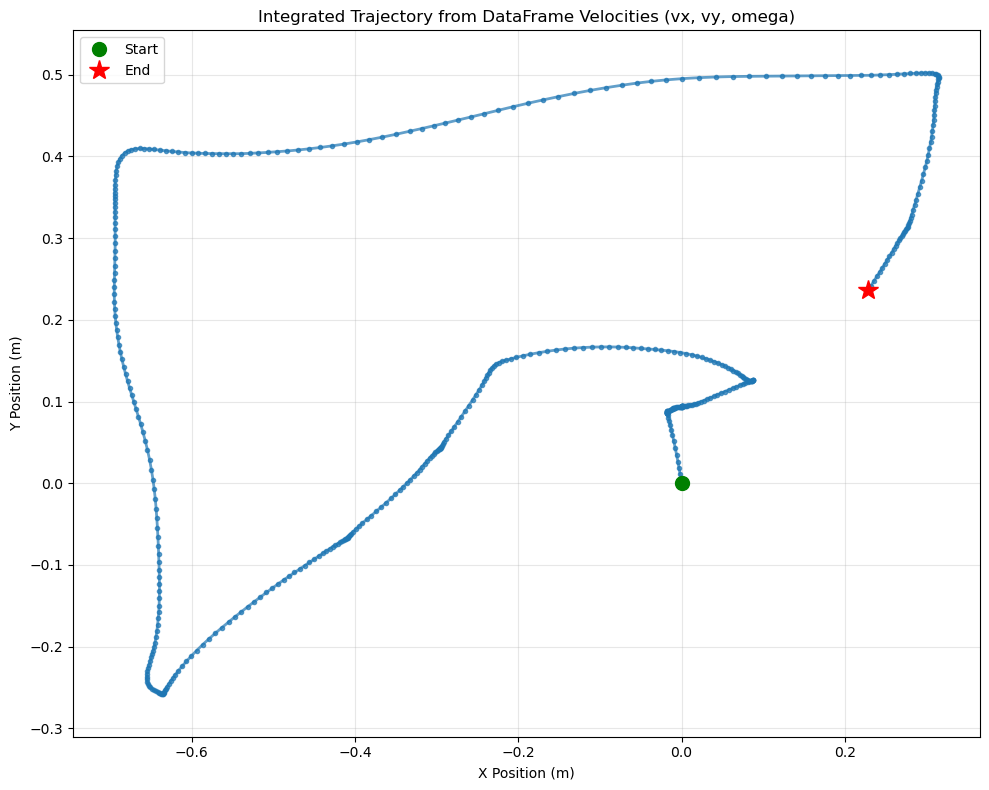

In [24]:
# Extract velocities from the DataFrame
velocities_from_df = list(zip(df['vx'], df['vy'], df['omega']))
velocities_from_df = velocities_from_df[0:500]
# Plot the trajectory using the integrated velocities
plot_trajectory_from_velocities(velocities_from_df, dt=0.016, title="Integrated Trajectory from DataFrame Velocities (vx, vy, omega)")